In [ ]:
#| default_exp clip_plot

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports and setup

### Unconditional imports

In [ ]:
#| export

from __future__ import division
import warnings

In [ ]:
#|export

from fastcore.all import *

from clip_plot import utils
from clip_plot.utils import clean_filename, timestamp

from clip_plot.utils import is_number, get_path, get_version, round_floats, write_json, read_json
from clip_plot.utils import date_to_seconds, round_date, datestring_to_date
from clip_plot.images import *
from clip_plot.embeddings import get_inception_vectors

from clip_plot.layouts import *

2023-03-28 10:27:00.671376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/wsanger/git/clip-plot/clip_plot/embeddings.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
#| export

warnings.filterwarnings("ignore")

In [ ]:
#| export

from os.path import join, exists, dirname, realpath
from shutil import rmtree
from distutils.dir_util import copy_tree
from pathlib import Path
import pkg_resources
import datetime
import argparse
from typing import Optional, List, Union, Tuple
import glob2
import uuid
import sys
import os

### Image processing imports

Note that I have removed the "copy-web-only" conditional import path for now

`nbdev` does not like cells to have cells to have code and imports in the same cell:

https://nbdev.fast.ai/getting_started.html#q-what-is-the-warning-found-a-cell-containing-mix-of-imports-and-computations.-please-use-separate-cells

I think this may mean we don't get to do conditional imports. If we find a code path that really should have conditional imports, we can see if there is a workaround. For now, I don't feel "copy web only" is a very important functionality to keep.

In [ ]:
#| export

from sklearn.metrics import pairwise_distances_argmin_min
from collections import defaultdict, namedtuple
from scipy.spatial.distance import cdist
from iiif_downloader import Manifest
from PIL import ImageFile
from tqdm.autonotebook import tqdm

import numpy as np
import random
import copy
import math
import gzip
import json
import csv


# Keras imports
# from tensorflow.keras.preprocessing.image import save_img, img_to_array, array_to_img
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3, imagenet_utils # imagenet_utils not being used
# from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow import compat
# surpress annoying info and warning logs from tensorflow
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

### Optional install imports

In [ ]:
#| export

DEFAULTS = {
    "images": None,
    "meta_dir": None,
    "out_dir": "output",
    "max_images": None,
    "use_cache": True,
    "encoding": "utf8",
    "min_cluster_size": 20,
    "max_clusters": 10,
    "atlas_size": 2048,
    "cell_size": 32,
    "lod_cell_height": 128, # Why is not in parser?
    "n_neighbors": [15],
    "min_dist": [0.01],
    "n_components": 2,
    "metric": "correlation",
    "pointgrid_fill": 0.05,
    "gzip": False,
    "min_size": 100,
    "min_score": 0.3,
    "min_vertices": 18,
    "plot_id": str(uuid.uuid1()),
    "seed": 24,
    "n_clusters": 12,
    "geojson": None,
}

FILE_NAME = "filename"  # Filename name key

# handle truncated images in PIL (managed by Pillow)
ImageFile.LOAD_TRUNCATED_IMAGES = True

"""
NB: Keras Image class objects return image.size as w,h
    Numpy array representations of images return image.shape as h,w,c
"""

'\nNB: Keras Image class objects return image.size as w,h\n    Numpy array representations of images return image.shape as h,w,c\n'


## Entry

`process_images` will kick off all the main functions for the module

In [ ]:
#|export

def get_clip_plot_root() -> Path:
    # ipython doesn't have __file__ attribute
    if in_ipython():
        return Path(utils.__file__).parents[1]
    else:
        print(__file__)
        return Path(__file__).parents[1]

In [ ]:
#| export

copy_root_dir = get_clip_plot_root()

In [ ]:
#| export

def process_images(**kwargs):
    """Main method for processing user images and metadata"""
    kwargs = preprocess_kwargs(**kwargs)

    copy_web_assets(out_dir=kwargs['out_dir'])
    if kwargs["copy_web_only"]:
        print(timestamp(), "Done!")
        sys.exit()
    
    np.random.seed(kwargs["seed"])
    compat.v1.set_random_seed(kwargs["seed"])
    kwargs["out_dir"] = join(kwargs["out_dir"], "data")
    kwargs["image_paths"], kwargs["metadata"] = filter_images(**kwargs)
    write_metadata(**kwargs)
    
    kwargs["atlas_dir"] = get_atlas_data(**kwargs)
    kwargs["vecs"] = get_inception_vectors(**kwargs)
    get_manifest(**kwargs)
    write_images(**kwargs)
    print(timestamp(), "Done!")


def preprocess_kwargs(**kwargs):
    """Preprocess incoming key word arguments
    Converts n_neighbors and min_dist arguments into a list

    Args:
        n_neighbors (int, list[int], default = [15])
        min_dist (int, list[int], default = [0.01])

    Notes:
        Convenient hook for preprocessing arguments
    
    """
    for i in ["n_neighbors", "min_dist"]:
        if not isinstance(kwargs[i], list):
            kwargs[i] = [kwargs[i]]
    return kwargs

In [ ]:
#| export

def copy_web_assets(out_dir: str) -> None:
    """Copy the /web directory from the clipplot source to the users cwd.
    Copies version number into assets.
    
    Args: 
        out_dir (str): directory to copy web assets

    Returns:
        None
    """
    copy_root_dir = get_clip_plot_root()
    src = copy_root_dir / "clip_plot/web"

    # resolve will handle cases with ../ in the path
    dest = Path.cwd() / Path(out_dir).resolve()
    utils.copytree_agnostic(src.as_posix(), dest.as_posix())

    # write version numbers into output
    for i in ["index.html", os.path.join("assets", "js", "tsne.js")]:
        path = join(dest, i)
        with open(path, "r") as f:
            f = f.read().replace("VERSION_NUMBER", get_version())
            with open(path, "w") as out:
                out.write(f)


## Images

In [ ]:
#| export

def filter_images(**kwargs):
    """Main method for filtering images given user metadata (if provided)

    -Validate image:
        Loading (done by stream_images and Images)
        Size
        resizing
        oblong

    -Compare against metadata

    
    Args:
        atlas_size (int, default = 2048)
        cell_size (int, default = 32)
        lod_cell_height (int, default = 128)
        shuffle (Optional[bool], default = False) 

    Returns:
        images (list[str])
        metadata (list[dict])

    Notes:
        Assumes 'filename' is provided in metadata
        Convoluted compiling of metadata
        Should All Validation should belong to Image class?
        Need to split function
    """
    # validate that input image names are unique
    image_paths = get_image_paths(images=kwargs["images"], out_dir=kwargs["out_dir"])
    image_names = list(map(clean_filename,image_paths))
    duplicates = set([x for x in image_names if image_names.count(x) > 1])

    if duplicates:
        raise Exception(
            """Image filenames should be unique, but the following 
            filenames are duplicated\n{}""".format("\n".join(duplicates)))
    
    # optionally shuffle the image_paths
    if kwargs.get("shuffle", False):
        print(timestamp(), "Shuffling input images")
        random.Random(kwargs["seed"]).shuffle(image_paths)
    else:
        image_paths = sorted(image_paths)

    # optionally limit the number of images in image_paths
    if kwargs.get("max_images", False):
        image_paths = image_paths[: kwargs["max_images"]]        

    # process and filter the images
    filtered_image_paths = {}
    oblong_ratio = kwargs["atlas_size"] / kwargs["cell_size"]
    for img in Image.stream_images(image_paths=image_paths):
        valid, msg = img.valid(lod_cell_height=kwargs["lod_cell_height"], oblong_ratio=oblong_ratio) 
        if valid is True:
            filtered_image_paths[img.path] = img.filename
        else:
            print(timestamp(), msg)

    # if there are no remaining images, throw an error
    if len(filtered_image_paths) == 0:
        raise Exception("No images were found! Please check your input image glob.")

    # handle the case user provided no metadata
    if not kwargs.get("meta_dir", False):
        return [filtered_image_paths.keys(), []]

    # handle user metadata: retain only records with image and metadata
    metaList = get_metadata_list(meta_dir=kwargs['meta_dir'])
    metaDict = {clean_filename(i.get(FILE_NAME, "")): i for i in metaList}
    meta_bn = set(metaDict.keys())
    img_bn = set(filtered_image_paths.values())

    # identify images with metadata and those without metadata
    meta_present = img_bn.intersection(meta_bn)
    meta_missing = list(img_bn - meta_bn)

    # notify the user of images that are missing metadata
    if meta_missing:
        print(
            timestamp(),
            " ! Some images are missing metadata:\n  -",
            "\n  - ".join(meta_missing[:10]),
        )
        if len(meta_missing) > 10:
            print(timestamp(), " ...", len(meta_missing) - 10, "more")

        if os.path.exists(kwargs['out_dir']) is False:
            os.makedirs(kwargs['out_dir'])
            
        missing_dir = os.path.join(kwargs['out_dir'],"missing-metadata.txt")
        with open(missing_dir, "w") as out:
            out.write("\n".join(meta_missing))

    if not meta_present:
        raise Exception( f"""No image has matching metadata. Check if '{FILE_NAME}' key was provided in metadata files""")

    # get the sorted lists of images and metadata
    images = []
    metadata = []
    for path, fileName in filtered_image_paths.items():
        if fileName in meta_present:
            images.append(path)
            metadata.append(copy.deepcopy(metaDict[fileName]))

    return [images, metadata]

In [ ]:
#| export

def get_image_paths(images:str, out_dir: str) -> List[str]:
    """Called once to provide a list of image paths--handles IIIF manifest input.
    
    args:
        images (str): directory location of images.
        out_dir (str): output directory for downloaded IIIF files.

    returns:
        image_paths list(str): list of image paths.

    Note:
        Old/previous images are not deleted from IIIF directory.

    Todo:
        Consider separate function that handles IIIF images
        from glob images.
    """

    image_paths = None

    # Is images a iiif file or image directory?
    if os.path.isfile(images):
        # Handle list of IIIF image inputs
        iiif_dir = os.path.join(out_dir,"iiif-downloads")

        # Check if directory already contains anything
        if os.path.exists(iiif_dir) and os.listdir(iiif_dir):
            print("Warning: IIIF directory already contains content!")

        with open(images) as f:
            urls = [url.strip() for url in f.read().split("\n") if url.startswith("http")]
            count = 0
            for url in urls:
                try:
                    Manifest(url=url, out_dir=iiif_dir).save_images(limit=1)
                    count += 1
                except:
                    print(timestamp(), "Could not download url " + url)

            if count == 0:
                raise Exception('No IIIF images were successfully downloaded!')

            image_paths = glob2.glob(os.path.join(out_dir,"iiif-downloads", "images", "*"))
   
    # handle case where images flag points to a glob of images
    if not image_paths:
        image_paths = glob2.glob(images)

    # handle case user provided no images
    if not image_paths:
        raise FileNotFoundError("Error: No input images were found. Please check your --images glob")

    return image_paths


In [ ]:
#| export

##
# Metadata
##


def get_metadata_list(meta_dir: str) -> List[dict]:
    """Return a list of objects with image metadata.

    Will create 'tags' key if 'category' is in metadata
    but not 'tags'.
    
    Args:
        metadata (str, default = None): Metadata location

    Returns:
        l (List[dict]): List of metadata 

    Notes:
        No check for 'filename' is performed

    Todo:
        Think about separating .csv and json functionality.
        Can we use pandas numpy to process csv?
    """

    # handle csv metadata
    metaList = []
    if meta_dir.endswith(".csv"):
        with open(meta_dir) as f:
            reader = csv.reader(f)
            headers = [i.lower() for i in next(reader)]
            for i in reader:
                metaList.append(
                    {
                        headers[j]: i[j] if len(i) > j and i[j] else ""
                        for j, _ in enumerate(headers)
                    }
                )
    
    # handle json metadata
    else:
        for i in glob2.glob(meta_dir):
            with open(i) as f:
                metaList.append(json.load(f))

    # if the user provided a category but not a tag, use the category as the tag
    for metaDict in metaList:
        if "category" in metaDict and ("tags" in metaDict) is False:
            metaDict.update({"tags": metaDict["category"]})
    return metaList

In [ ]:
#| export

def write_metadata(metadata, **kwargs):
    """Write list `metadata` of objects to disk
    
    Args:
        metadata (list[dict])
        out_dir (str)

        subfunctions:
            write_json():
                gzip (Optional[bool]):
                encoding (Optional[str]): Required if gzip is provided
                    default = 'utf8'

    Returns:
        None

    Notes:
        Improve variable naming
    
    """
    if not metadata:
        return

    out_dir = join(kwargs["out_dir"], "metadata")
    for i in ["filters", "options", "file"]:
        out_path = join(out_dir, i)
        if not exists(out_path):
            os.makedirs(out_path)
    
    # create the lists of images with each tag
    d = defaultdict(list)
    for i in metadata:
        filename = clean_filename(i[FILE_NAME])
        i["tags"] = [j.strip() for j in i.get("tags", "").split("|")]
        for j in i["tags"]:
            d["__".join(j.split())].append(filename)
        write_json(os.path.join(out_dir, "file", filename + ".json"), i, **kwargs)

    write_json(
        os.path.join(out_dir, "filters", "filters.json"),
        [
            {
                "filter_name": "select",
                "filter_values": list(d.keys()),
            }
        ],
        **kwargs
    )

    # create the options for the category dropdown
    for i in d:
        write_json(os.path.join(out_dir, "options", i + ".json"), d[i], **kwargs)
    # create the map from date to images with that date (if dates present)
    date_d = defaultdict(list)
    for i in metadata:
        date = i.get("year", "")
        if date:
            date_d[date].append(clean_filename(i[FILE_NAME]))

    # find the min and max dates to show on the date slider
    dates = np.array([int(i.strip()) for i in date_d if is_number(i)])
    domain = {"min": float("inf"), "max": -float("inf")}
    mean = np.mean(dates)
    std = np.std(dates)
    for i in dates:
        # update the date domain with all non-outlier dates
        if abs(mean - i) < (std * 4):
            domain["min"] = int(min(i, domain["min"]))
            domain["max"] = int(max(i, domain["max"]))

    # write the dates json
    if len(date_d) > 1:
        write_json(
            os.path.join(out_dir, "dates.json"),
            {
                "domain": domain,
                "dates": date_d,
            },
            **kwargs
        )

In [ ]:
#| export

##
# Main
##


def get_manifest(**kwargs):
    """Create and return the base object for the manifest output file
    
    Args:
        atlas_dir (str)
        image_paths (str)
        plot_id (str, default = str(uuid.uuid1()))
        out_dir (str)
        metadata (list[dict]): Only checking if provided
        gzip (bool, default = False)
        atlas_size (int, default = 2048)
        cell_size (int, default = 32)
        lod_cell_height (int, default = 128)

        Need to check subfunctions


    Returns:
        None

    Notes:
        Original description is inadequate
        Function is to big (god function)
    
    """
    # load the atlas data
    atlas_data = json.load(open(join(kwargs["atlas_dir"], "atlas_positions.json")))
    # store each cell's size and atlas position
    atlas_ids = set([i["idx"] for i in atlas_data])
    sizes = [[] for _ in atlas_ids]
    pos = [[] for _ in atlas_ids]
    for idx, i in enumerate(atlas_data):
        sizes[i["idx"]].append([i["w"], i["h"]])
        pos[i["idx"]].append([i["x"], i["y"]])
    # obtain the paths to each layout's JSON positions
    layouts = get_layouts(**kwargs)
    # create a heightmap for the umap layout
    if "umap" in layouts and layouts["umap"]:
        get_heightmap(layouts["umap"]["variants"][0]["layout"], "umap", **kwargs)
    # specify point size scalars
    point_sizes = {}
    point_sizes["min"] = 0
    point_sizes["grid"] = 1 / math.ceil(len(kwargs["image_paths"]) ** (1 / 2))
    point_sizes["max"] = point_sizes["grid"] * 1.2
    point_sizes["scatter"] = point_sizes["grid"] * 0.2
    point_sizes["initial"] = point_sizes["scatter"]
    point_sizes["categorical"] = point_sizes["grid"] * 0.6
    point_sizes["geographic"] = point_sizes["grid"] * 0.025
    # fetch the date distribution data for point sizing
    if "date" in layouts and layouts["date"]:
        date_layout = read_json(layouts["date"]["labels"], **kwargs)
        point_sizes["date"] = 1 / (
            (date_layout["cols"] + 1) * len(date_layout["labels"])
        )
    # create manifest json
    manifest = {
        "version": get_version(),
        "plot_id": kwargs["plot_id"],
        "output_directory": os.path.split(kwargs["out_dir"])[0],
        "layouts": layouts,
        "initial_layout": "umap",
        "point_sizes": point_sizes,
        "imagelist": get_path("imagelists", "imagelist", **kwargs),
        "atlas_dir": kwargs["atlas_dir"],
        "metadata": True if kwargs["metadata"] else False,
        "default_hotspots": get_hotspots(layouts=layouts, **kwargs),
        "custom_hotspots": get_path(
            "hotspots", "user_hotspots", add_hash=False, **kwargs
        ),
        "gzipped": kwargs["gzip"],
        "config": {
            "sizes": {
                "atlas": kwargs["atlas_size"],
                "cell": kwargs["cell_size"],
                "lod": kwargs["lod_cell_height"],
            },
        },
        "creation_date": datetime.datetime.today().strftime("%d-%B-%Y-%H:%M:%S"),
    }
    # write the manifest without gzipping
    no_gzip_kwargs = {
        "out_dir": kwargs["out_dir"],
        "gzip": False,
        "plot_id": kwargs["plot_id"],
    }
    path = get_path("manifests", "manifest", **no_gzip_kwargs)
    write_json(path, manifest, **no_gzip_kwargs)
    path = get_path(None, "manifest", add_hash=False, **no_gzip_kwargs)
    write_json(path, manifest, **no_gzip_kwargs)
    # create images json
    imagelist = {
        "cell_sizes": sizes,
        "images": [clean_filename(i) for i in kwargs["image_paths"]],
        "atlas": {
            "count": len(atlas_ids),
            "positions": pos,
        },
    }
    write_json(manifest["imagelist"], imagelist, **kwargs)

In [ ]:
#| export

##
# Atlases
##


def get_atlas_data(**kwargs):
    """
    Generate and save to disk all atlases to be used for this visualization
    If square, center each cell in an nxn square, else use uniform height

    Args:
        out_dir (str)
        plot_id (str, default = str(uuid.uuid1()))
        use_cache (bool, default = False)
        shuffle (Optional[bool], default = False)
        atlas_size (int, default = 2048)
        cell_size (int, default = 32)
        lod_cell_height (int, default = 128)


    Returns:
        out_dir (str): Atlas location 

    Notes:

    """
    # if the atlas files already exist, load from cache
    out_dir = os.path.join(kwargs["out_dir"], "atlases", kwargs["plot_id"])
    if (
        os.path.exists(out_dir)
        and kwargs["use_cache"]
        and not kwargs.get("shuffle", False)
    ):
        print(timestamp(), "Loading saved atlas data")
        return out_dir
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    # else create the atlas images and store the positions of cells in atlases
    print(timestamp(), "Creating atlas files")
    n = 0  # number of atlases
    x = 0  # x pos in atlas
    y = 0  # y pos in atlas
    positions = []  # l[cell_idx] = atlas data
    atlas = np.zeros((kwargs["atlas_size"], kwargs["atlas_size"], 3))
    for idx, i in enumerate(Image.stream_images(image_paths=kwargs["image_paths"], metadata=kwargs["metadata"])):
        cell_data = i.resize_to_height(kwargs["cell_size"])
        _, v, _ = cell_data.shape
        appendable = False
        if (x + v) <= kwargs["atlas_size"]:
            appendable = True
        elif (y + (2 * kwargs["cell_size"])) <= kwargs["atlas_size"]:
            y += kwargs["cell_size"]
            x = 0
            appendable = True
        if not appendable:
            save_atlas(atlas, out_dir, n)
            n += 1
            atlas = np.zeros((kwargs["atlas_size"], kwargs["atlas_size"], 3))
            x = 0
            y = 0
        atlas[y : y + kwargs["cell_size"], x : x + v] = cell_data
        # find the size of the cell in the lod canvas
        lod_data = i.resize_to_max(kwargs["lod_cell_height"])
        h, w, _ = lod_data.shape  # h,w,colors in lod-cell sized image `i`
        positions.append(
            {
                "idx": n,  # atlas idx
                "x": x,  # x offset of cell in atlas
                "y": y,  # y offset of cell in atlas
                "w": w,  # w of cell at lod size
                "h": h,  # h of cell at lod size
            }
        )
        x += v
    save_atlas(atlas, out_dir, n)
    out_path = os.path.join(out_dir, "atlas_positions.json")
    with open(out_path, "w") as out:
        json.dump(positions, out)
    return out_dir


def save_atlas(atlas, out_dir, n):
    """Save an atlas to disk"""
    out_path = join(out_dir, "atlas-{}.jpg".format(n))
    save_image(out_path, atlas)

# Parse the command-line arguments

In [ ]:
#| export

def parse():
    """Read command line args and begin data processing"""
    description = "Create the data required to create a clipplot viewer"
    parser = argparse.ArgumentParser(
        description=description, formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument(
        "--images",
        "-i",
        type=str,
        default=DEFAULTS["images"],
        help="path to a glob of images to process",
        required=False,
    )
    parser.add_argument(
        "--metadata",
        "-m",
        type=str,
        default=DEFAULTS["meta_dir"],
        help="path to a csv or glob of JSON files with image metadata (see readme for format)",
        required=False,
    )
    parser.add_argument(
        "--max_images",
        type=int,
        default=DEFAULTS["max_images"],
        help="maximum number of images to process from the input glob",
        required=False,
    )
    parser.add_argument(
        "--use_cache",
        type=bool,
        default=DEFAULTS["use_cache"],
        help="given inputs identical to prior inputs, load outputs from cache",
        required=False,
    )
    parser.add_argument(
        "--encoding",
        type=str,
        default=DEFAULTS["encoding"],
        help="the encoding of input metadata",
        required=False,
    )
    parser.add_argument(
        "--min_cluster_size",
        type=int,
        default=DEFAULTS["min_cluster_size"],
        help="the minimum number of images in a cluster",
        required=False,
    )
    parser.add_argument(
        "--max_clusters",
        type=int,
        default=DEFAULTS["max_clusters"],
        help="the maximum number of clusters to return",
        required=False,
    )
    parser.add_argument(
        "--out_dir",
        type=str,
        default=DEFAULTS["out_dir"],
        help="the directory to which outputs will be saved",
        required=False,
    )
    parser.add_argument(
        "--cell_size",
        type=int,
        default=DEFAULTS["cell_size"],
        help="the size of atlas cells in px",
        required=False,
    )
    parser.add_argument(
        "--n_neighbors",
        nargs="+",
        type=int,
        default=DEFAULTS["n_neighbors"],
        help="the n_neighbors arguments for UMAP",
    )
    parser.add_argument(
        "--min_dist",
        nargs="+",
        type=float,
        default=DEFAULTS["min_dist"],
        help="the min_dist arguments for UMAP",
    )
    parser.add_argument(
        "--n_components",
        type=int,
        default=DEFAULTS["n_components"],
        help="the n_components argument for UMAP",
    )
    parser.add_argument(
        "--metric",
        type=str,
        default=DEFAULTS["metric"],
        help="the metric argument for umap",
    )
    parser.add_argument(
        "--pointgrid_fill",
        type=float,
        default=DEFAULTS["pointgrid_fill"],
        help="float 0:1 that determines sparsity of jittered distributions (lower means more sparse)",
    )
    parser.add_argument(
        "--copy_web_only",
        action="store_true",
        help="update ./output/assets without reprocessing data",
    )
    parser.add_argument(
        "--min_size",
        type=float,
        default=DEFAULTS["min_size"],
        help="min size of cropped images",
    )
    parser.add_argument(
        "--gzip", action="store_true", help="save outputs with gzip compression"
    )
    parser.add_argument(
        "--shuffle",
        action="store_true",
        help="shuffle the input images before data processing begins",
    )
    parser.add_argument(
        "--plot_id",
        type=str,
        default=DEFAULTS["plot_id"],
        help="unique id for a plot; useful for resuming processing on a started plot",
    )
    parser.add_argument(
        "--seed", type=int, default=DEFAULTS["seed"], help="seed for random processes"
    )
    parser.add_argument(
        "--n_clusters",
        type=int,
        default=DEFAULTS["n_clusters"],
        help="number of clusters to use when clustering with kmeans",
    )
    parser.add_argument(
        "--geojson",
        type=str,
        default=DEFAULTS["geojson"],
        help="path to a GeoJSON file with shapes to be rendered on a map",
    )
    config = DEFAULTS.copy()
    if in_ipython():
        config.update(vars(parser.parse_args({})))
    else:
        config.update(vars(parser.parse_args()))

    return config

## Carlo's Test Functions
# Need to remove later

In [ ]:
#| export
def test_iiif(config):
    test_images = copy_root_dir/"tests/IIIF_examples/iif_example.txt"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    # meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    # config["meta_dir"] = meta_dir.as_posix()

    return config


def test_butterfly_duplicate(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs_duplicates/**/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()

    return config


def test_butterfly(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"
    
    config["test_mode"] = True

    return config


def test_butterfly_missing_meta(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/meta_missing_filename.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()

    return config


def test_no_meta_dir(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()

    return config


In [ ]:
#| export

@call_parse
def project_imgs(images:Param(type=str,
                        help="path to a glob of images to process"
                        )=DEFAULTS["images"],
                metadata:Param(type=str,
                        help="path to a csv or glob of JSON files with image metadata (see readme for format)"
                        )=DEFAULTS["meta_dir"],
                max_images:Param(type=int,
                        help="maximum number of images to process from the input glob"
                        )=DEFAULTS["max_images"],
                use_cache:Param(type=bool,
                        help="given inputs identical to prior inputs, load outputs from cache"
                        )=DEFAULTS["use_cache"],
                encoding:Param(type=str,
                        help="the encoding of input metadata"
                        )=DEFAULTS["encoding"],
                min_cluster_size:Param(type=int,
                        help="the minimum number of images in a cluster",
                        required=False
                        )=DEFAULTS["min_cluster_size"],
                max_clusters:Param(type=int,
                        help="the maximum number of clusters to return",
                        required=False
                        )=DEFAULTS["max_clusters"],
                out_dir:Param(type=str,
                        help="the directory to which outputs will be saved",
                        required=False
                        )=DEFAULTS["out_dir"],
                cell_size:Param(type=int,
                        help="the size of atlas cells in px",
                        required=False
                        )=DEFAULTS["cell_size"],
                n_neighbors:Param(type=int,
                        nargs="+",
                        help="the n_neighbors arguments for UMAP"
                        )=DEFAULTS["n_neighbors"],
                min_dist:Param(type=float,
                        nargs="+",
                        help="the min_dist arguments for UMAP"
                        )=DEFAULTS["min_dist"],
                n_components:Param(type=int,
                        help="the n_components argument for UMAP"
                        )=DEFAULTS["n_components"],
                metric:Param(type=str,
                        help="the metric argument for umap"
                        )=DEFAULTS["metric"],
                pointgrid_fill:Param(type=float,
                        help="float 0:1 that determines sparsity of jittered distributions (lower means more sparse)"
                        )=DEFAULTS["pointgrid_fill"],
                copy_web_only:Param(type=bool,
                        action="store_true",
                        help="update ./output/assets without reprocessing data"
                        )=False,
                min_size:Param(type=float,
                        help="min size of cropped images"
                        )=DEFAULTS["min_size"],
                gzip:Param(type=bool,
                        action="store_true", help="save outputs with gzip compression"
                        )=False,
                shuffle:Param(type=bool,
                        action="store_true",
                        help="shuffle the input images before data processing begins"
                        )=False,
                plot_id:Param(type=str,
                        help="unique id for a plot; useful for resuming processing on a started plot"
                        )=DEFAULTS["plot_id"],
                seed:Param(type=int, help="seed for random processes"
                           )=DEFAULTS["seed"],
                n_clusters:Param(type=int,
                        help="number of clusters if using kmeans"
                        )=DEFAULTS["n_clusters"],
                geojson:Param(type=str,
                        help="path to a GeoJSON file with shapes to be rendered on a map"
                        )=DEFAULTS["geojson"]
                ):
                "Convert a folder of images into a clip-plot visualization"

                config = parse()
                copy_root_dir = get_clip_plot_root()

                if in_ipython() and config["images"] == None:
                        print("we're in ipython")
                        # at least for now, this means we're in testing mode.
                        # TODO: pass explicit "test_mode" flag
                        config = test_butterfly(config)

                process_images(**config)

we're in ipython
2023-03-28 10:27:13.825727: Creating atlas files
2023-03-28 10:27:14.553759: Creating Inception vectors for 12 images


2023-03-28 10:27:14.791114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 10:27:14.813074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 10:27:14.813654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 10:27:14.815245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in 

2023-03-28 10:27:20.290623: Creating image array


  0%|          | 0/12 [00:00<?, ?it/s]

2023-03-28 10:27:23.851974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-28 10:27:24.858296: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-28 10:27:24.956646: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-28 10:27:24.956706: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-28 10:27:25.054616: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-28 10:27:25.054732: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 0s 44ms/step
2023-03-28 10:27:29.008876: Creating single umap layout
2023-03-28 10:27:36.538568: Creating umap pointgrid
2023-03-28 10:27:36.566670: Creating grid layout
2023-03-28 10:27:36.567596: Creating rasterfairy layout
2023-03-28 10:27:37.574547: Coonswarp rectification could not be performed list index out of range
2023-03-28 10:27:37.580202: Creating date layout with 3 columns
2023-03-28 10:27:37.581703: Could not parse datestring 1999
2023-03-28 10:27:37.581738: Could not parse datestring 2002
2023-03-28 10:27:37.581748: Could not parse datestring 1975
2023-03-28 10:27:37.581755: Could not parse datestring 2001
2023-03-28 10:27:37.581763: Could not parse datestring 2003
2023-03-28 10:27:37.581770: Could not parse datestring 2000
2023-03-28 10:27:37.581777: Could not parse datestring 1994
2023-03-28 10:27:37.581785: Could not parse datestring 1999
2023-03-28 10:27:37.581792: Could not parse datestring 2010
2023-03-28 10:27:37.581799: Coul

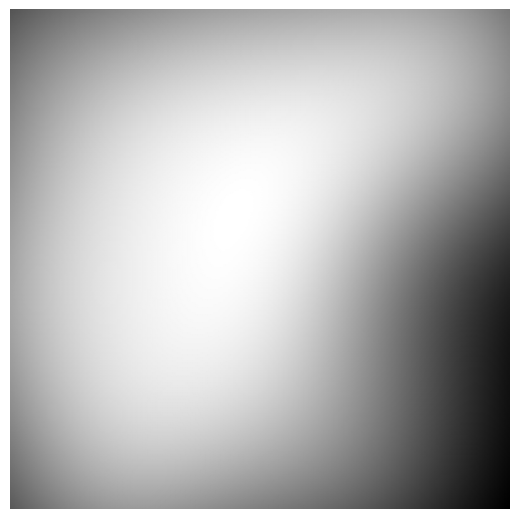

In [ ]:
#| export

if __name__ == "__main__":
    project_imgs()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()